## ME 592 Final Project
### Jake Bergfeld, Mohammad Rashid Mohammad Shoaib
#### Engineering Image Analysis - Automated Chest X-ray classifier

Gathering data from Kaggle - Link to data: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
# !pip install kaggle
# !mkdir .kaggle  #naming required by kaggle API, creates a hidden folder
# !cp /home/exouser/Downloads/kaggle.json /home/exouser/.kaggle/kaggle.json

#### Confirming location of Kaggle API token was moved successfully

In [2]:
# !cd .kaggle && ls

#### Downloading the specific dataset and confirming locations

In [ ]:
!kaggle datasets list -s 'Chest X-ray images'

In [ ]:
# !kaggle datasets download -d 'paultimothymooney/chest-xray-pneumonia'

In [ ]:
# !sudo apt-get install unzip
# !unzip chest-xray-pneumonia.zip /home/exouser/ME592/Final Project

## Data Information:
### Input image size varies
#### The 2 classes to predict are:
- Normal/Healthy lungs
- Pneumonia  <br>
##### Formula to calculate the number of parameters in a CNN:

- Convolutional layer: (in_channels x out_channels x kernel_height x kernel_width) + out_channels
- Batch normalization layer: 2 x num_features
- ReLU activation layer: 0 (no parameters)
- Max pooling layer: 0 (no parameters)
- Fully connected layer: (in_features x out_features) + out_features

#### Library Imports & Transforming Data

In [3]:
import os 
import random
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm 
from torch import nn 
import torch.nn.functional as F 
from torchvision import transforms as T, datasets
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid

In [4]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.empty_cache()

cpu


In [5]:
# #Only run this once to generate test and train data and create separate folders for each

# import os
# import random
# import shutil

# # Set the path to the 'Train & Test' folder
# folder_path = '/home/exouser/data/imgs/Train & Test'

# # Set the path to the 'Train' folder
# train_path = '/home/exouser/data/imgs/Train & Test/Train'

# # Set the path to the 'Test' folder
# test_path = '/home/exouser/data/imgs/Train & Test/Test'

# # Loop through each subfolder in the 'Train & Test' folder
# for subfolder in os.listdir(folder_path):

#     # Create a new subfolder in the 'Train' folder with the same name
#     train_subfolder = os.path.join(train_path, subfolder)
#     os.makedirs(train_subfolder, exist_ok=True)

#     # Create a new subfolder in the 'Test' folder with the same name
#     test_subfolder = os.path.join(test_path, subfolder)
#     os.makedirs(test_subfolder, exist_ok=True)

#     # List all the image files in the subfolder
#     images = os.listdir(os.path.join(folder_path, subfolder))
#     random.shuffle(images)

#     # Calculate the number of images to move to the 'Train' folder
#     split_index = int(len(images) * 0.7)

#     # Move the first 70% of images to the 'Train' folder
#     for image in images[:split_index]:
#         source = os.path.join(folder_path, subfolder, image)
#         destination = os.path.join(train_subfolder, image)
#         shutil.copyfile(source, destination)

#     # Move the remaining 30% of images to the 'Test' folder
#     for image in images[split_index:]:
#         source = os.path.join(folder_path, subfolder, image)
#         destination = os.path.join(test_subfolder, image)
#         shutil.copyfile(source, destination)

#### Load Dataset 

In [6]:
#Defining a class to store hyperparameters and file paths used in the code for easy modification.
class CFG:
    # define the hyperparameters
    epochs = 1                                         # No. of epochs of training the model 
    lr = 0.001                                         # Learning rate 
    batch_size = 16                                    # Batch Size For Dataset 
    img_size = 224
        
    #Directory path for the training & test images
    DATA_DIR ="/home/exouser/ME592/Final Project/chest-xray-pneumonia"
    TEST = 'test'                                      # Test folder name in data directory 
    TRAIN = 'train'                                    # Train folder name in data directory 
    VAL ='val'                                         # Valid folder name in data directory 

#### Image Transformation 

In [7]:
train_transform = T.Compose([
            
    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.RandomRotation(degrees = (-20,+20)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

valid_transform = T.Compose([
    
    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    
    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [8]:
train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)
valid_path = os.path.join(CFG.DATA_DIR, CFG.VAL)
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)

trainset = datasets.ImageFolder(train_path,transform = train_transform)
validset = datasets.ImageFolder(valid_path,transform = valid_transform)
testset = datasets.ImageFolder(test_path,transform = test_transform)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/home/exouser/ME592/Final Project/chest-xray-pneumonia\\train'

In [5]:
print("Trainset Size : {}".format(len(trainset)))
print("Validset Size : {}".format(len(validset)))
print("Testset Size : {}".format(len(testset)))

Trainset Size : 5216
Validset Size : 16
Testset Size : 624


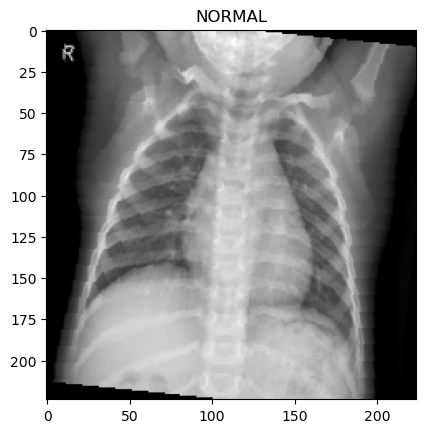

In [6]:
def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)
        
image, label = trainset[2]

class_names = ['NORMAL','PNEUMONIA']

show_image(image,class_names[label])

#### Load Dataset into Batches 

In [7]:
trainloader = DataLoader(trainset, batch_size = CFG.batch_size , shuffle = True)
validloader = DataLoader(validset, batch_size = CFG.batch_size , shuffle = True)
testloader = DataLoader(testset, batch_size = CFG.batch_size , shuffle = True)

In [12]:
# print(len(trainloader))
# print(len(trainloader.dataset))

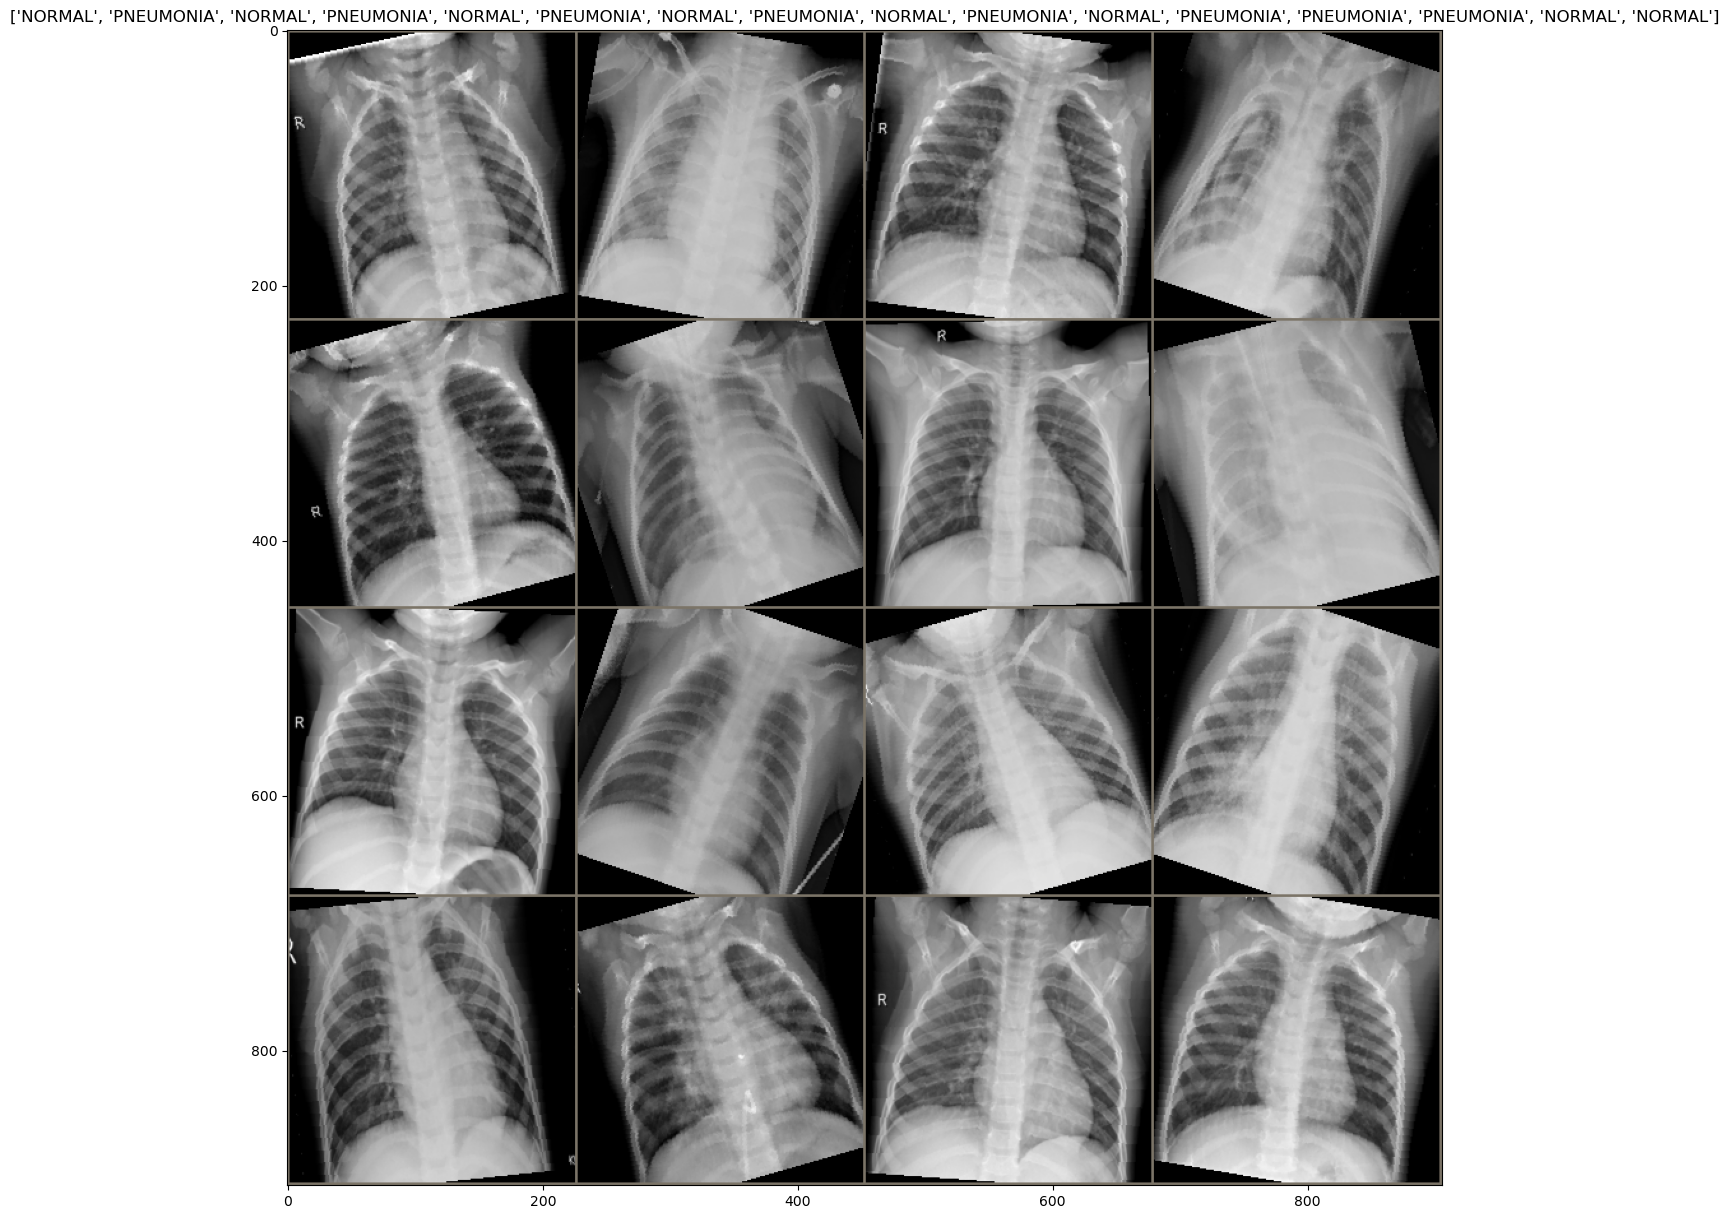

In [13]:
def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)
        
dataiter = iter(trainloader)
images,labels = next(dataiter)

out = make_grid(images,nrow=4)

show_grid(out, title=[class_names[x] for x in labels])

#### Convolutional Neural Network  

In [14]:
#CNN Network
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (N,3,224,244)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (N,12,224,224)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (N,12,224,224)
        self.relu1=nn.ReLU()
        #Shape= (N,12,224,224)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (N,12,112,112)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (N,20,112,112)
        self.relu2=nn.ReLU()
        #Shape= (N,20,112,112)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (N,32,112,112)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (N,32,112,112)
        self.relu3=nn.ReLU()
        #Shape= (N,32,112,112)
        
        
        self.fc=nn.Linear(in_features=112 * 112 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (N,32,112,112)
            
        output=output.view(-1,32*112*112)
            
            
        output=self.fc(output)
            
        return output
            

In [15]:
model=ConvNet(num_classes=2).to(device)

In [16]:
def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

#### Trainer

In [17]:
class PneumoniaTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train()
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader)
            
            model.eval()
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader)
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'BestPneumoniaModel.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

#### Model Training

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = PneumoniaTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validloader,epochs = CFG.epochs)

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.13435643911361694
Epoch : 1 Train Loss : 4.537474 Train Acc : 0.898390
Epoch : 1 Valid Loss : 0.134356 Valid Acc : 0.875000


#### Reulsts and Testing 

In [19]:
model.load_state_dict(torch.load('C:/Users/mbshoa/OneDrive - Emerson/Desktop/ME 592/Final_project/BestPneumoniaModel.pt'))

model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/39 [00:00<?, ?it/s]

Test Loss : 2.9047049001039853
Test Acc : 0.8365384340286255


Image Index # =  504


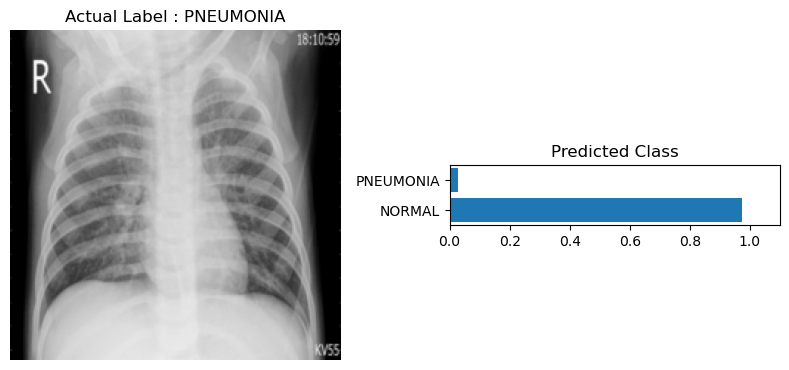

In [32]:
def view_classify(image,ps,label):
    
    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Actual Label : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    
# Select a random index from 0 to 623
idx = random.randint(0, 623)
print('Image Index # = ',idx)
image,label = testset[idx] # enter the image index

logit = model(image.to(device).unsqueeze(0)) 
ps = F.softmax(logit,dim = 1)

view_classify(image,ps,label)